# <a id='toc1_'></a>[Efficiency Analysis](#toc0_)
This notebook demonstrates the use of `EfficiencyAnalysis` class in `src/analysis/vram_usage.py` for analyzing the efficiency of jobs, users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Efficiency Analysis](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc1_2_)    
    - [User efficiency metrics](#toc1_2_1_)    
      - [Find Inefficient Users based on alloc_vram_efficiency](#toc1_2_1_1_)    
      - [Find Inefficient Users based on vram_hours](#toc1_2_1_2_)    
    - [PI group metrics](#toc1_2_2_)    
      - [Find inefficient PIs](#toc1_2_2_1_)    
  - [Example: Analyze all jobs with no VRAM constraints](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [1]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [2]:
project_root = str(Path.cwd().resolve().parent)
print(f"Project root: {project_root}")

Project root: C:\Users\Nitya Karthik A\ds4cg-job-analytics


In [3]:
# Add project root to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis import vram_usage

# Automatically reload modules before executing code
# This is useful for development to see changes without restarting the kernel.
%load_ext autoreload
# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 1
%aimport src.analysis.vram_usage, src.preprocess.preprocess, src.config.enum_constants

In [5]:
# Load the jobs DataFrame from DuckDB
query = f"SELECT * FROM Jobs WHERE ('a100' in GPUType or 'h100' in GPUType) AND GPUs == 1"

efficiency_analysis = vram_usage.EfficiencyAnalysis(
	db_path='../data/slurm_data.db', query=query
)

display(efficiency_analysis.jobs_df.head(10))
print(efficiency_analysis.jobs_df.shape)

Connected to ../data/slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.
Disconnected from ../data/slurm_data.db
Unique GPU types found for debugging purposes: ['a100' 'h100'], SELECT * FROM Jobs WHERE ('a100' in GPUType or 'h100' in GPUType) AND GPUs == 1


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs
0,38750282,<NA>,-1,bash,False,shell,pi_chuangg_umass_edu,jiabenchen_umass_edu,['a100'],normal,...,{'a100': 1},0.000000e+00,0.0,1.701478e+07,0.000080,0 days 00:11:57,<NA>,80,32,22625
1,38754198,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_mshao_umassd_edu,vbandi_umassd_edu,['x86_64'],normal,...,{'a100': 1},7.157580e+09,38.0,1.714425e+10,3.148984,0 days 00:00:19,<NA>,80,83,661
2,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,...,{'a100': 1},1.525049e+10,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,45,4495
3,38755853,<NA>,-1,Template_Pendulum.sh,False,non-interactive,pi_gfelder_smith_edu,zji_smith_edu,['gpu:a100'],normal,...,{'a100': 1},0.000000e+00,0.0,2.815717e+09,48.104427,0 days 00:00:27,40,80,54,54
4,38767669,<NA>,-1,bash,False,shell,pi_donghyunkim_umass_edu,soowangyang_umass_edu,['gpu:a100'],normal,...,{'a100': 1},0.000000e+00,0.0,1.412309e+09,0.089295,0 days 01:26:40,40,80,7,126
5,38772272,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_mendres_umass_edu,ppenta_umass_edu,"['vram80', 'gpu:a100']",normal,...,{'a100': 1},0.000000e+00,0.0,2.073360e+10,0.742180,0 days 00:00:19,80,80,40,40
6,38777804,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,{'a100': 1},5.054136e+08,77.0,3.440394e+08,98.004761,0 days 00:00:28,<NA>,80,43775,43775
7,38777806,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,{'a100': 1},0.000000e+00,0.0,3.466895e+08,99.955582,0 days 00:00:09,<NA>,80,43775,43775
8,38778439,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,{'a100': 1},5.054136e+08,74.0,3.487375e+08,99.940666,0 days 00:00:23,<NA>,40,43775,43775
9,38779093,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,{'a100': 1},5.054136e+08,75.0,3.485778e+08,99.922623,0 days 00:00:28,<NA>,40,43775,43775


(221363, 31)


In [6]:
print(efficiency_analysis.jobs_df)

           JobID  ArrayJobID  ArrayID                       JobName  IsArray  \
0       38750282        <NA>       -1                          bash    False   
1       38754198        <NA>       -1  sys/dashboard/sys/bc_jupyter    False   
2       38755106        <NA>       -1                   interactive    False   
3       38755853        <NA>       -1          Template_Pendulum.sh    False   
4       38767669        <NA>       -1                          bash    False   
...          ...         ...      ...                           ...      ...   
279029  40130961        <NA>       -1                        job.sh    False   
279030  40130966        <NA>       -1                        job.sh    False   
279032  40130998        <NA>       -1                        job.sh    False   
279033  40131017        <NA>       -1                        job.sh    False   
279041  40132655        <NA>       -1                   interactive    False   

            Interactive                

## <a id='toc1_2_'></a>[Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc0_)


In [7]:
# Analyze workload efficiency of GPU users with no VRAM constraints who used 0 GB of VRAM
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,  # No VRAM constraints
    gpu_mem_usage_filter=0,  # Used 0 GB of VRAM
)

metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)


jobs_with_metrics = metrics_dict['jobs_with_efficiency_metrics']
users_with_metrics = metrics_dict['users_with_efficiency_metrics']
pi_accounts_with_metrics = metrics_dict['pi_accounts_with_efficiency_metrics']

# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,Memory,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs,job_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,used_cpu_gib
0,38750282,<NA>,-1,bash,False,shell,pi_chuangg_umass_edu,jiabenchen_umass_edu,['a100'],normal,TIMEOUT,SUCCESS,2025-06-26 16:37:02,2025-06-26 16:48:59,0 days 08:00:11,0 days 00:08:00,gpu,[gpu022],16,40960,1,{'a100': 1},0.000000e+00,0.0,1.701478e+07,0.000080,0 days 00:11:57,<NA>,80,32,22625,8.003056,0.000000,0.000000,<NA>,-inf,0.015846
1,38754198,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_mshao_umassd_edu,vbandi_umassd_edu,['x86_64'],normal,TIMEOUT,SUCCESS,2025-06-26 17:22:47,2025-06-26 17:23:06,0 days 08:00:05,0 days 00:08:00,umd-cscdr-gpu,[umd-cscdr-gpu002],8,16384,1,{'a100': 1},7.157580e+09,38.0,1.714425e+10,3.148984,0 days 00:00:19,<NA>,80,83,661,8.001389,6.666016,0.083325,<NA>,-19.883486,15.966827
6,38777804,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 22:16:01,2025-06-26 22:16:29,0 days 01:44:01,0 days 00:02:00,gpu-preempt,[gpu018],1,8192,1,{'a100': 1},5.054136e+08,77.0,3.440394e+08,98.004761,0 days 00:00:28,<NA>,80,43775,43775,1.733611,0.470703,0.005884,<NA>,-8.903054,0.320412
7,38777806,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 22:18:22,2025-06-26 22:18:31,0 days 01:42:33,0 days 00:02:00,gpu-preempt,[umd-cscdr-gpu001],1,8192,1,{'a100': 1},0.000000e+00,0.0,3.466895e+08,99.955582,0 days 00:00:09,<NA>,80,43775,43775,1.709167,0.000000,0.000000,<NA>,-inf,0.322880
8,38778439,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 22:48:02,2025-06-26 22:48:25,0 days 01:46:21,0 days 00:02:00,gpu-preempt,[ece-gpu001],1,8192,1,{'a100': 1},5.054136e+08,74.0,3.487375e+08,99.940666,0 days 00:00:23,<NA>,40,43775,43775,1.772500,0.470703,0.011768,<NA>,-7.874167,0.324787
9,38779093,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:01:42,2025-06-26 23:02:10,0 days 01:43:21,0 days 00:02:00,gpu-preempt,[ece-gpu002],1,8192,1,{'a100': 1},5.054136e+08,75.0,3.485778e+08,99.922623,0 days 00:00:28,<NA>,40,43775,43775,1.722500,0.470703,0.011768,<NA>,-7.652046,0.324638
10,38779171,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:11:47,2025-06-26 23:12:17,0 days 01:38:59,0 days 00:02:00,gpu-preempt,[ece-gpu001],1,8192,1,{'a100': 1},5.054136e+08,76.0,3.461448e+08,99.899124,0 days 00:00:30,<NA>,40,43775,43775,1.649722,0.470703,0.011768,<NA>,-7.328738,0.322372
12,38779276,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:24:17,2025-06-26 23:24:26,0 days 00:46:49,0 days 00:00:59,gpu-preempt,[ece-gpu002],1,8192,1,{'a100': 1},4.970250e+08,76.0,2.885714e+08,99.891739,0 days 00:00:09,<NA>,40,43775,43775,0.780278,0.462891,0.011572,<NA>,-3.479371,0.268753
13,38779517,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:34:15,2025-06-26 23:34:33,0 days 01:43:02,0 days 00:02:00,gpu-preempt,[uri-gpu003],1,8192,1,{'a100': 1},0.000000e+00,0.0,3.451167e+08,99.930107,0 days 00:00:18,<NA>,80,43775,43775,1.717222,0.000000,0.000000,<NA>,-inf,0.321415
14,38779546,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:36:13,2025-06-26 23:36:35,0 days 00:43:47,0 days 00:00:59,gpu-preempt,[ece-gpu00

Jobs found: 96107


### <a id='toc1_2_1_'></a>[User efficiency metrics](#toc0_)

In [8]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,expected_value_alloc_vram_efficiency,expected_value_gpu_count,vram_hours
0,aabedeen_umass_edu,10,166.107778,pi_pkatz_umass_edu,0.599789,1.0,13288.622222
1,aagrawal_umass_edu,341,682.591944,pi_jdomke_umass_edu,0.778086,1.0,54567.200000
2,aamballa_umass_edu,155,2336.916111,pi_mccallum_umass_edu,0.564882,1.0,186953.288889
3,aaronsun_umass_edu,846,11164.919167,pi_gvanhorn_umass_edu,0.583044,1.0,893193.533333
4,aatmakuru_umass_edu,15,104.688333,pi_hzamani_umass_edu,0.827154,1.0,8357.566667
...,...,...,...,...,...,...,...
355,zeyuanyang_umass_edu,794,4137.355833,pi_chuangg_umass_edu,0.188682,1.0,325802.588889
356,zhehuanchen_umass_edu,96,404.815556,pi_chuangg_umass_edu,0.131584,1.0,31905.044444
357,zhexu_umass_edu,471,2110.765278,pi_mzink_umass_edu,0.242484,1.0,168329.777778
358,zhipengtang_umass_edu,6,5.371111,pi_elearned_umass_edu,0.128047,1.0,295.022222


#### <a id='toc1_2_1_1_'></a>[Find Inefficient Users based on alloc_vram_efficiency](#toc0_)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,expected_value_alloc_vram_efficiency,expected_value_gpu_count,vram_hours
32,anthony_bowers_student_uml_edu,448,3236.678889,pi_subash_sharma_uml_edu,0.0,1.0,257013.033333
40,asajeeda_umassd_edu,18,144.062500,pi_mshao_umassd_edu,0.0,1.0,11525.000000
52,bdahrooge_uri_edu,5,5.016667,pi_bdahrooge_uri_edu,0.0,1.0,401.333333
46,aukale_umass_edu,6,14.234444,pi_bnl_umass_edu,0.0,1.0,1138.755556
54,bmuhwezi_umass_edu,18,50.248611,pi_jtaneja_umass_edu,0.0,1.0,3806.211111
147,jnariani_umass_edu,7,32.445278,pi_pflaherty_umass_edu,0.0,1.0,2595.622222
117,hhargrove_umass_edu,11,350.942778,pi_xiaohuizhang_umass_edu,0.0,1.0,28075.422222
90,dmohapatra_umass_edu,2159,6783.526389,pi_dmohapatra_umass_edu,0.0,1.0,542566.366667
129,jadenugba_uri_edu,6,30.025000,pi_kelum_gajamannage_uri_edu,0.0,1.0,2402.000000
156,kaichunliu_umass_edu,307,1612.942500,pi_sunghoonlee_umass_edu,0.0,1.0,127820.022222


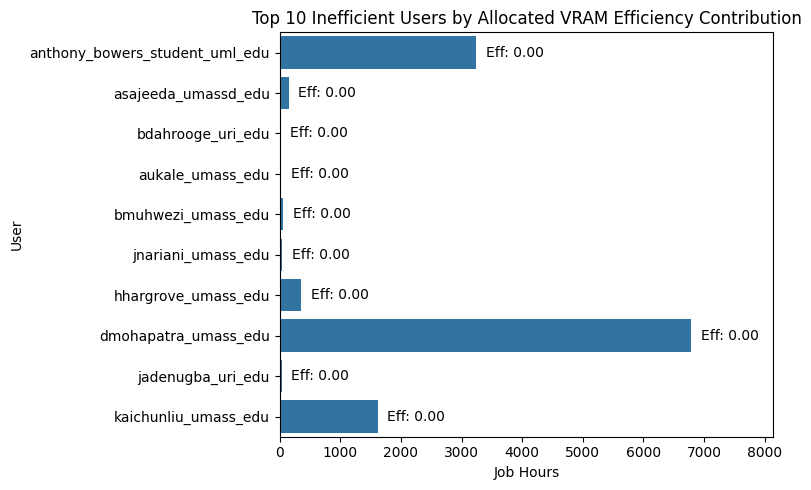

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

inefficient_users = efficiency_analysis.find_inefficient_users_by_alloc_vram_efficiency(
    alloc_vram_efficiency_filter={"max": 0.3, "inclusive": True},  # criteria for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)

# Display top inefficient users by job count
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users.head(10))



# Plot top inefficient users by GPU hours, with efficiency as labels
top_users = inefficient_users.head(10)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["user_job_hours"],
    orient="h"
)
plt.xlabel("Job Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by Allocated VRAM Efficiency Contribution")

# Annotate bars with expected_value_alloc_vram_efficiency, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["user_job_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.20 if xmax > 0 else 1
ax.set_xlim(0, xlim)

# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (job_hours, efficiency) in enumerate(
    zip(
        top_users["user_job_hours"],
        top_users["expected_value_alloc_vram_efficiency"],
        strict=True,
    )
):
    # Place annotation at min(job_hours + 2% of xlim, 98% of xlim)
    xpos = min(job_hours + xlim * 0.02, xlim * 0.98)
    # If bar is very close to right spine, nudge annotation left to avoid overlap
    if xpos > xlim * 0.96:
        xpos = xlim * 0.96
    ax.text(
        xpos,
        i,
        f"Eff: {efficiency:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )

plt.tight_layout()
plt.show()

#### <a id='toc1_2_1_2_'></a>[Find Inefficient Users based on vram_hours](#toc0_)


Top inefficient users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,expected_value_alloc_vram_efficiency,expected_value_gpu_count,vram_hours
260,rvmathew_umass_edu,43756,45688.648889,pi_grason_umass_edu,0.005781,1.0,3.465102e+06
237,poojan_patel001_umb_edu,1051,17612.125278,pi_atreya_chakraborty_umb_edu,0.236497,1.0,1.382862e+06
111,gkhanna_uri_edu,266,17021.320556,pi_gkhanna_uri_edu,0.036009,1.0,1.361706e+06
63,cecile_cres_uri_edu,4148,16220.809444,pi_yingzhang_uri_edu,0.331822,1.0,1.288393e+06
3,aaronsun_umass_edu,846,11164.919167,pi_gvanhorn_umass_edu,0.583044,1.0,8.931935e+05
176,mchasmai_umass_edu,1184,10454.641667,pi_gvanhorn_umass_edu,0.232271,1.0,8.363713e+05
101,elobo_umass_edu,2271,8343.365000,pi_yzick_umass_edu,0.155158,1.0,6.527398e+05
334,xwang3_umass_edu,951,7072.653889,pi_jdomke_umass_edu,0.069188,1.0,5.658123e+05
90,dmohapatra_umass_edu,2159,6783.526389,pi_dmohapatra_umass_edu,0.000000,1.0,5.425664e+05
178,mdashrafulis_umass_edu,133,6671.541389,pi_mserafini_umass_edu,0.300739,1.0,5.335670e+05


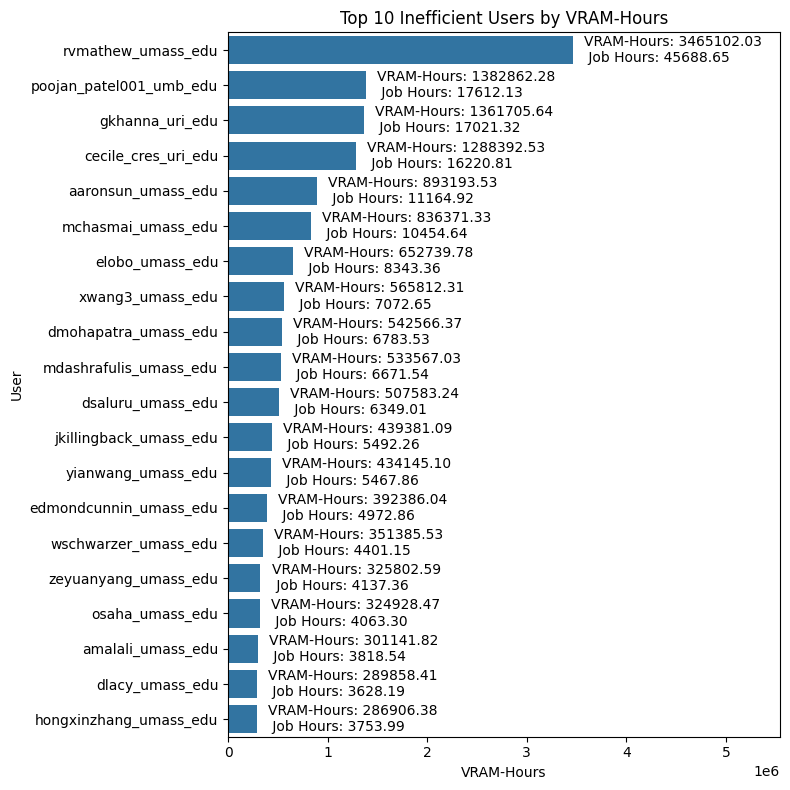

In [10]:
inefficient_users_vram_hours = efficiency_analysis.find_inefficient_users_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient users by VRAM-hours:")
display(inefficient_users_vram_hours.head(20))

top_users = inefficient_users_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["vram_hours"],
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, user_job_hours) in enumerate(
    zip(
        top_users["vram_hours"],
        top_users["user_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {user_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

### <a id='toc1_2_2_'></a>[PI group metrics](#toc0_)

In [11]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,expected_value_alloc_vram_efficiency,expected_value_gpu_count
0,pi_ashgiri_uri_edu,96,1111.495833,2,88919.666667,0.026004,1.0
1,pi_prada_uri_edu,2,7.804444,1,624.355556,0.000000,1.0
2,pi_yuchen_wang_umb_edu,1,6.007222,1,480.577778,0.141724,1.0
3,pi_marlin_umass_edu,14,26.452222,1,1715.788889,0.190422,1.0
4,pi_pthomas_umass_edu,4130,8029.345000,2,641243.944444,0.083314,1.0
...,...,...,...,...,...,...,...
144,pi_mshao_umassd_edu,591,4281.190278,6,342495.222222,0.201470,1.0
145,pi_mfiterau_umass_edu,2024,7550.927500,9,598311.466667,0.569860,1.0
146,pi_mzink_umass_edu,643,2601.499167,3,207565.077778,0.223507,1.0
147,pi_dmohapatra_umass_edu,2159,6783.526389,1,542566.366667,0.000000,1.0


#### <a id='toc1_2_2_1_'></a>[Find inefficient PIs](#toc0_)


Top inefficient PI Groups by VRAM-hours:


,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,expected_value_alloc_vram_efficiency,expected_value_gpu_count
124,pi_grason_umass_edu,43756,45688.648889,1,3.465102e+06,0.005781,1.0
123,pi_gvanhorn_umass_edu,3040,27645.600556,5,2.211512e+06,0.389505,1.0
69,pi_chuangg_umass_edu,3877,19539.626667,19,1.527249e+06,0.265572,1.0
127,pi_gkhanna_uri_edu,276,17556.629722,3,1.404530e+06,0.035146,1.0
36,pi_atreya_chakraborty_umb_edu,1077,17794.159722,2,1.397425e+06,0.234209,1.0
66,pi_yingzhang_uri_edu,4148,16220.809444,1,1.288393e+06,0.331822,1.0
143,pi_mccallum_umass_edu,1646,11789.863333,16,9.393583e+05,0.485297,1.0
114,pi_hongyu_umass_edu,2476,10645.463611,14,8.440467e+05,0.664905,1.0
39,pi_hzamani_umass_edu,1124,9008.703889,12,7.206386e+05,0.562345,1.0
72,pi_yzick_umass_edu,2271,8343.365000,1,6.527398e+05,0.155158,1.0


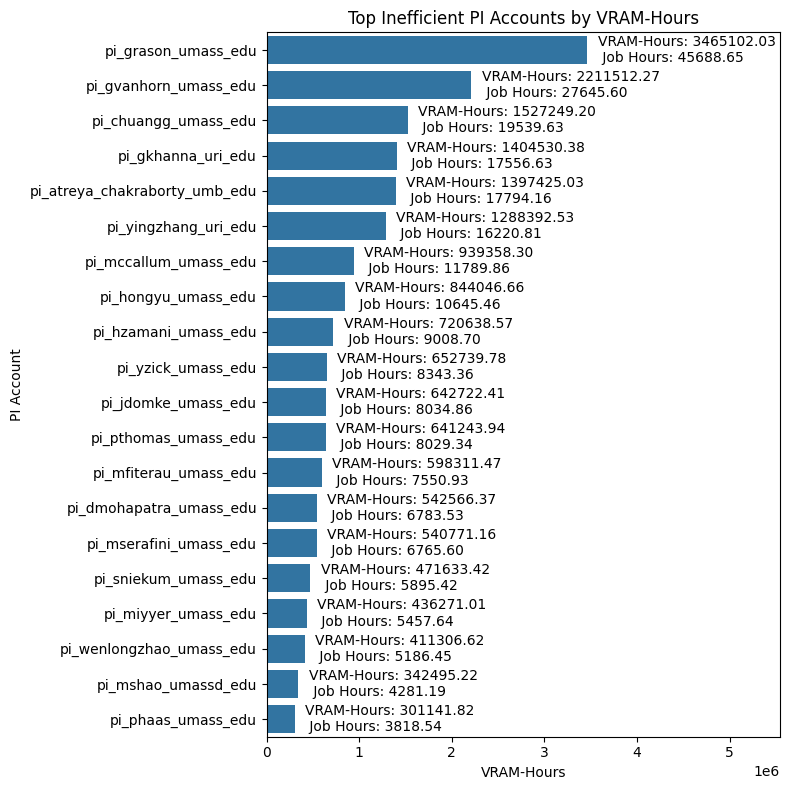

In [12]:
inefficient_pi_vram_hours = efficiency_analysis.find_inefficient_pis_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient PI Groups by VRAM-hours:")
display(inefficient_pi_vram_hours.head(20))

top_pi_accounts = inefficient_pi_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_pi_accounts["pi_account"],
    x=top_pi_accounts["pi_acc_vram_hours"],
    order=top_pi_accounts["pi_account"].tolist(),  # Only show present values
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("PI Account")
plt.title("Top Inefficient PI Accounts by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_pi_accounts["pi_acc_vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, pi_acc_job_hours) in enumerate(
    zip(
        top_pi_accounts["pi_acc_vram_hours"],
        top_pi_accounts["pi_acc_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {pi_acc_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Example: Analyze all jobs with no VRAM constraints](#toc0_)

In [13]:
# Filter jobs where no VRAM constraint was set but a GPU was allocated

filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter={"min": 0, "inclusive": False},  # No VRAM constraints
    gpu_count_filter={"min": 1, "inclusive": True}  # At least one GPU allocated
)

jobs_with_metrics = efficiency_analysis.calculate_job_efficiency_metrics(filtered_jobs)

# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,Memory,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs,job_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,used_cpu_gib
2,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,TIMEOUT,SUCCESS,2025-06-26 18:16:35,2025-06-26 18:17:01,0 days 08:00:10,0 days 00:08:00,superpod-a100,[gpu013],8,204800,1,{'a100': 1},1.525049e+10,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,45,4495,8.002778,14.203125,0.177539,0.355078,-13.833319,103.428574
3,38755853,<NA>,-1,Template_Pendulum.sh,False,non-interactive,pi_gfelder_smith_edu,zji_smith_edu,['gpu:a100'],normal,COMPLETED,SUCCESS,2025-06-26 18:32:51,2025-06-26 18:33:18,0 days 07:24:47,0 days 00:48:00,gpu-preempt,[uri-gpu003],32,80000,1,{'a100': 1},0.000000e+00,0.0,2.815717e+09,48.104427,0 days 00:00:27,40,80,54,54,7.413056,0.000000,0.000000,0.0,-inf,2.622341
4,38767669,<NA>,-1,bash,False,shell,pi_donghyunkim_umass_edu,soowangyang_umass_edu,['gpu:a100'],normal,TIMEOUT,SUCCESS,2025-06-26 20:58:58,2025-06-26 22:25:38,0 days 02:00:02,0 days 00:02:00,gpu,[gpu022],8,122880,1,{'a100': 1},0.000000e+00,0.0,1.412309e+09,0.089295,0 days 01:26:40,40,80,7,126,2.000556,0.000000,0.000000,0.0,-inf,1.315315
5,38772272,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_mendres_umass_edu,ppenta_umass_edu,"['vram80', 'gpu:a100']",normal,TIMEOUT,SUCCESS,2025-06-26 21:52:38,2025-06-26 21:52:57,0 days 04:00:14,0 days 00:04:00,gpu-preempt,[uri-gpu007],8,32768,1,{'a100': 1},0.000000e+00,0.0,2.073360e+10,0.742180,0 days 00:00:19,80,80,40,40,4.003889,0.000000,0.000000,0.0,-inf,19.309669
11,38779240,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_hongyu_umass_edu,sahgupta_umass_edu,"['vram80', 'gpu:a100']",normal,TIMEOUT,SUCCESS,2025-06-26 23:20:07,2025-06-26 23:20:23,0 days 01:00:17,0 days 00:01:00,gpu-preempt,[umd-cscdr-gpu001],8,32768,1,{'a100': 1},0.000000e+00,0.0,2.323059e+10,2.393937,0 days 00:00:16,80,80,12,4944,1.004722,0.000000,0.000000,0.0,-inf,21.635174
57,38781593,<NA>,-1,interactive,False,shell,pi_hongyu_umass_edu,hkolukuluru_umass_edu,"['a100', 'vram80']",normal,COMPLETED,SUCCESS,2025-06-27 01:45:20,2025-06-27 01:45:33,0 days 00:47:24,0 days 00:02:00,gpu-preempt,[umd-cscdr-gpu001],2,102400,1,{'a100': 1},0.000000e+00,0.0,6.312774e+10,5.343407,0 days 00:00:13,80,80,24,4944,0.790000,0.000000,0.000000,0.0,-inf,58.792286
69,38782127,<NA>,-1,batch_job_geval.sh,False,non-interactive,pi_wenlongzhao_umass_edu,dmaram_umass_edu,"['a100', 'vram80']",normal,COMPLETED,SUCCESS,2025-06-27 02:12:27,2025-06-27 02:12:48,0 days 01:06:17,0 days 00:04:00,gpu-preempt,[uri-gpu007],2,20480,1,{'a100': 1},0.000000e+00,0.0,2.146906e+10,49.341312,0 days 00:00:21,80,80,218,3748,1.104722,0.000000,0.000000,0.0,-inf,19.994617
70,38782167,<NA>,-1,batch_job_geval.sh,False,non-interactive,pi_wenlongzhao_umass_edu,dmaram_umass_edu,"['a100', 'vram80']",normal,COMPLETED,SUCCESS,2025-06-27 02:16:11,2025-06-27 02:16:20,0 days 01:03:42,0 days 00:04:00,gpu-preempt,[uri-gpu007],2,20480,1,{'a100': 1},0.000000e+00,0.0,2.146916e+10,49.540894,0 days 00:00:09,80,80,218,3748,1.061667,0.000000,0.000000,0.0,-inf,19.994709
81,38675199,<NA>,-1,attn_head_retrieval_head_o_proj_finetuning_lla...,False,non-interactive,pi_mccallum_umass_edu,anshitagupta_umass_edu,"['bf16', 'vram80']",normal,TIMEOUT,SUCCESS,2025-06-25 18:46:18,2025-06-25 18:46:42,1 days 00:00:11,0 days 00:24:00,superpod-a100,[gpu016],1,30720,1,{'a100': 1},6.704176e+10,100.0,3.217558e+10,99.526695,0 days 00:00:24,80,80,272,2632,24.003056,62.437500,0.780469,0.780469,-5.949411,29.965847
82,38481618,<NA>,-1,3W_mix_64_5_1.7_4_pamnet,False,non-interactive,pi_zhoulin_umass_edu,siqichen_umass_edu,['gpu:a100'],normal,PREEMPTED,SUCCESS,2025-06-25 22:00:15,202

Jobs found: 39502


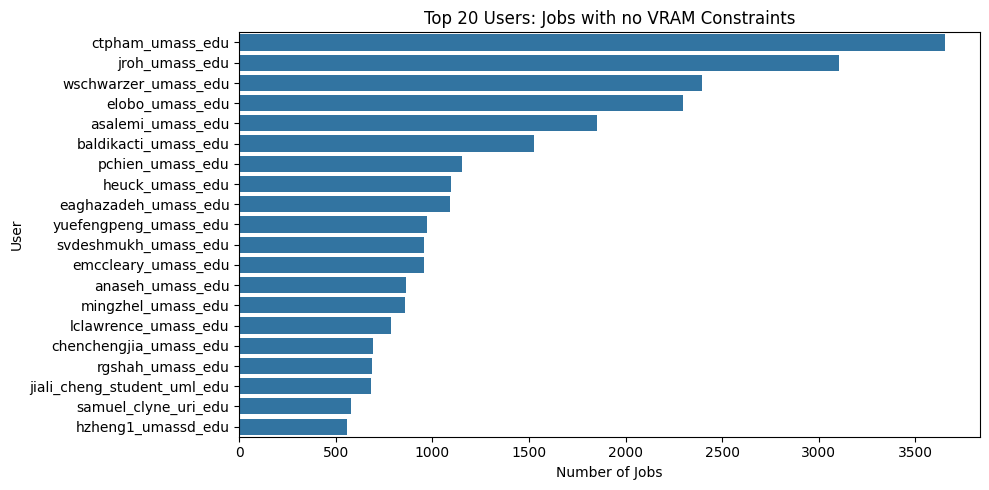

In [14]:
# Plot top users by number of jobs with no VRAM constraints
if not filtered_jobs.empty:
    plt.figure(figsize=(10, 5))
    user_counts = filtered_jobs["User"].value_counts().head(20)
    sns.barplot(x=user_counts.values, y=user_counts.index, orient="h")
    plt.xlabel("Number of Jobs")
    plt.ylabel("User")
    plt.title("Top 20 Users: Jobs with no VRAM Constraints")
    plt.tight_layout()
    plt.show()
else:
    print("No jobs found without VRAM constraints.")

In [39]:
#Aggregate by GPU type 
aggregated_metrics = efficiency_analysis.aggregate_gpu_metrics_by_query(
)
print(aggregated_metrics)


Unique GPU types found: Index(['a100', 'h100'], dtype='object', name='GPUType')
                                           A100         H100
Mean Used GPU Memory (GiB)            15.726353    23.589733
Median Used GPU Memory (GiB)           1.169922     6.948242
Mean Requested VRAM Efficiency         0.490629     0.581318
Median Requested VRAM Efficiency       0.302002     0.320801
Mean Allocated VRAM Efficiency         0.198681     0.294872
Median Allocated VRAM Efficiency       0.014771     0.086853
Total GPU Hours                   463260.707222  8325.313889
Mean Weighted VRAM Efficiency          0.302050     0.311373
Median Weighted VRAM Efficiency        0.010864     0.097579


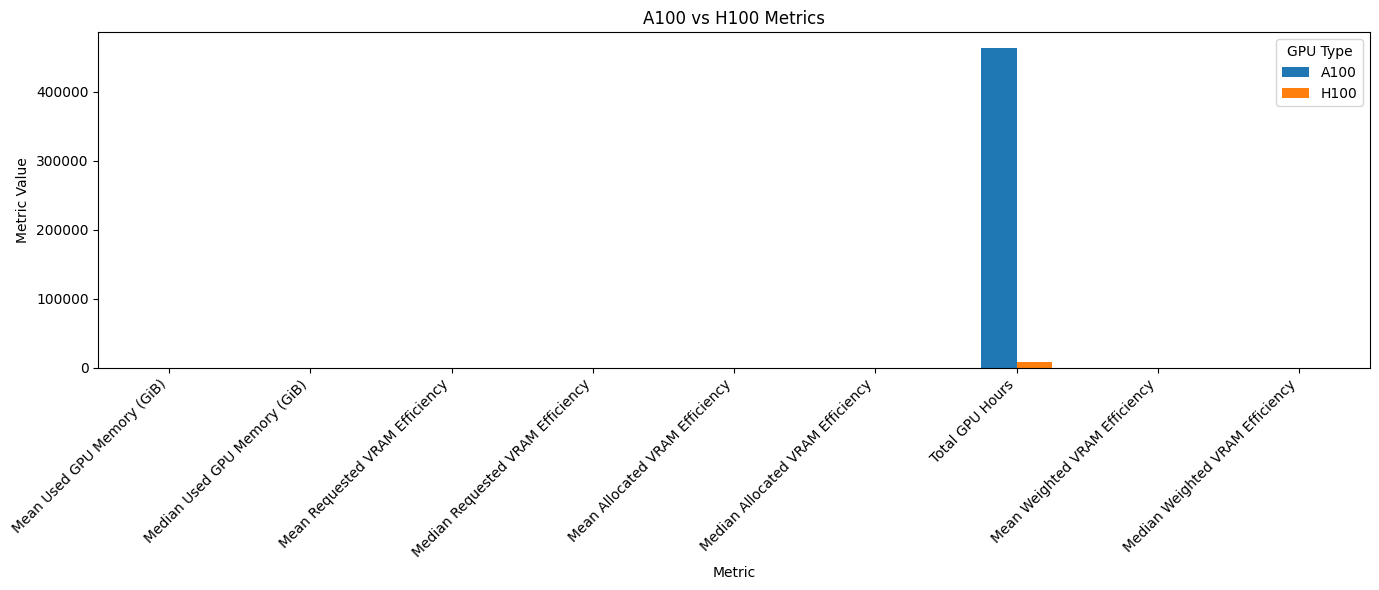

In [45]:
# Create DataFrame directly from dict of dicts or series
metrics_plot = pd.DataFrame(aggregated_metrics)

# Ensure the index is correct (i.e., metrics are rows)
if metrics_plot.columns.str.contains("A100").any():
    metrics_plot = metrics_plot  # already in correct shape
else:
    metrics_plot = metrics_plot.T  # transpose if A100/H100 are rows instead

# Optional: Set proper row labels if needed
metrics_plot.index.name = "Metric"

# Plot
ax = metrics_plot.plot(kind='bar', figsize=(14, 6))
ax.set_ylabel("Metric Value")
ax.set_title("A100 vs H100 Metrics")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='GPU Type')
plt.show()


In [ ]:
#within a100 
efficiency_analysis.query = f"SELECT * FROM Jobs WHERE 'a100' in GPUType AND GPUs == 1"
print(efficiency_analysis.query)
#filter out jobs who have used more than 0 GB of VRAM
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,  # No VRAM constraints
    gpu_mem_usage_filter = 0,  # Used 0 GB of VRAM
)
metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)
print(metrics_dict['jobs_with_efficiency_metrics'].head(10))

#filter out jobs who have used more than 0 GB of VRAM
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,  # No VRAM constraints
    gpu_mem_usage_filter=0,  # Used 0 GB of VRAM
)

SELECT * FROM Jobs WHERE 'a100' in GPUType AND GPUs == 1
       JobID  ArrayJobID  ArrayID                       JobName  IsArray  \
0   38750282        <NA>       -1                          bash    False   
1   38754198        <NA>       -1  sys/dashboard/sys/bc_jupyter    False   
6   38777804        <NA>       -1                        job.sh    False   
7   38777806        <NA>       -1                        job.sh    False   
8   38778439        <NA>       -1                        job.sh    False   
9   38779093        <NA>       -1                        job.sh    False   
10  38779171        <NA>       -1                        job.sh    False   
12  38779276        <NA>       -1                        job.sh    False   
13  38779517        <NA>       -1                        job.sh    False   
14  38779546        <NA>       -1                        job.sh    False   

        Interactive               Account                  User  \
0             shell  pi_chuangg_umass_e

In [53]:
# Step 1: Remove query filtering — instead do GPUType filtering in Python
efficiency_analysis.query = None  # Disable raw SQL filtering
jobs_df = efficiency_analysis.jobs_df.copy()

# Step 2: Filter for A100 GPUType (assumes GPUType is a dict)
a100_jobs = jobs_df[
    jobs_df["GPUType"].apply(lambda x: isinstance(x, dict) and "a100" in x)
]

# Optional: filter for 1 GPU
a100_jobs = a100_jobs[a100_jobs["GPUs"] == 1]

# Step 3: Manually assign jobs_df to analyze only A100 jobs
efficiency_analysis.jobs_df = a100_jobs

# Step 4: Split into two filtered sets
# 4a. Used 0 GB of VRAM
zero_vram_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,
    gpu_mem_usage_filter=0,
)

# 4b. Used > 0 GB of VRAM
nonzero_vram_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,
    gpu_mem_usage_filter={"min": 1, "inclusive": True},  # > 0 bytes
)

# Step 5: Calculate and aggregate metrics for both groups
metrics_zero = efficiency_analysis.calculate_all_efficiency_metrics(zero_vram_jobs)['jobs_with_efficiency_metrics']
metrics_nonzero = efficiency_analysis.calculate_all_efficiency_metrics(nonzero_vram_jobs)['jobs_with_efficiency_metrics']

# Step 6: Aggregate summary
summary = pd.DataFrame({
    "Used 0 VRAM": [
        metrics_zero["GPUMemUsage"].mean() / (2**30),
        metrics_zero["alloc_vram_efficiency"].mean(),
        metrics_zero["job_hours"].sum()
    ],
    "Used > 0 VRAM": [
        metrics_nonzero["GPUMemUsage"].mean() / (2**30),
        metrics_nonzero["alloc_vram_efficiency"].mean(),
        metrics_nonzero["job_hours"].sum()
    ]
}, index=[
    "Mean GPU Memory Used (GiB)",
    "Mean Allocated VRAM Efficiency",
    "Total GPU Hours"
])

# Step 7: Add job counts and percentages
count_zero = len(metrics_zero)
count_nonzero = len(metrics_nonzero)
total_jobs = count_zero + count_nonzero

percent_zero = count_zero / total_jobs * 100
percent_nonzero = count_nonzero / total_jobs * 100

# Add to summary
summary.loc["Job Count"] = [count_zero, count_nonzero]
summary.loc["% of Jobs"] = [percent_zero, percent_nonzero]
print("\nSummary of A100 Jobs with and without VRAM Usage:")
print(summary)


Summary of A100 Jobs with and without VRAM Usage:
                                  Used 0 VRAM  Used > 0 VRAM
Mean GPU Memory Used (GiB)          13.641190      15.620564
Mean Allocated VRAM Efficiency       0.172261       0.197256
Total GPU Hours                 300225.350556  255021.896111
Job Count                        95426.000000   83334.000000
% of Jobs                           53.382188      46.617812


In [55]:
# Filter for H100 jobs
h100_jobs = efficiency_analysis.jobs_df[
    efficiency_analysis.jobs_df["GPUType"].apply(lambda x: isinstance(x, dict) and "h100" in x)
]

# Optional: limit to 1 GPU
h100_jobs = h100_jobs[h100_jobs["GPUs"] == 1]

# Assign to class for analysis
efficiency_analysis.jobs_df = h100_jobs

# Jobs that used 0 GB VRAM
h100_zero_vram = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,
    gpu_mem_usage_filter=0
)

# Jobs that used > 0 GB VRAM
h100_nonzero_vram = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,
    gpu_mem_usage_filter={"min": 1, "inclusive": True}
)
# Calculate job-level metrics
metrics_zero = efficiency_analysis.calculate_all_efficiency_metrics(h100_zero_vram)['jobs_with_efficiency_metrics']
metrics_nonzero = efficiency_analysis.calculate_all_efficiency_metrics(h100_nonzero_vram)['jobs_with_efficiency_metrics']

# Aggregate results
summary_h100 = pd.DataFrame({
    "Used 0 VRAM": [
        metrics_zero["GPUMemUsage"].mean() / (2**30),
        metrics_zero["alloc_vram_efficiency"].mean(),
        metrics_zero["job_hours"].sum()
    ],
    "Used > 0 VRAM": [
        metrics_nonzero["GPUMemUsage"].mean() / (2**30),
        metrics_nonzero["alloc_vram_efficiency"].mean(),
        metrics_nonzero["job_hours"].sum()
    ]
}, index=[
    "Mean GPU Memory Used (GiB)",
    "Mean Allocated VRAM Efficiency",
    "Total GPU Hours"
])

# Add counts and percentages
count_zero = len(metrics_zero)
count_nonzero = len(metrics_nonzero)
total = count_zero + count_nonzero
summary_h100.loc["Job Count"] = [count_zero, count_nonzero]
summary_h100.loc["% of Jobs"] = [count_zero / total * 100, count_nonzero / total * 100]

print(summary_h100)


KeyError: 'GPUs'